In [ ]:

# Analysis Plan for Aromatic-Hybrid 3.0 Library Generation and Evaluation
# 
# Step 1: Load aromatic_hybrid_2.0_designs.csv and identify top 5 unique 9-mer motifs
#         by most favorable (most negative) contact-masked MJ score
# 
# Step 2: Generate triple mutants by introducing a third mutation at non-mutated positions
#         - Aromatic substitutions: any position -> W, F, Y (if not already aromatic)
#         - Conservative substitutions: BLOSUM62 score > 0
# 
# Step 3: Create full-length designs by grafting onto 3 scaffolds (1FNA, 1TEN, 2QMT)
# 
# Step 4: Filter for novelty using 10-aa sliding window against:
#         - known_niv_binders_full.fasta
#         - cdr_library_summary.csv
#         - allosteric_cdr_library.csv
# 
# Step 5: Score using 30th percentile contact-masked MJ against 31-residue allosteric epitope
# 
# Step 6: Statistical comparison between Aromatic-Hybrid 3.0 and 2.0 libraries
# 
# Expected limitations:
# - MJ scoring has intrinsic aromatic bias
# - Third mutations may show diminishing returns
# - Novelty filtering may eliminate some high-scoring designs

import pandas as pd
import numpy as np
from Bio import SeqIO
from scipy import stats
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("Analysis plan defined. Starting execution...")


Analysis plan defined. Starting execution...


In [ ]:

# Step 1: Load aromatic_hybrid_2.0_designs.csv and identify top 5 unique 9-mer motifs
# Most favorable = most negative contact-masked MJ score

df_2_0 = pd.read_csv('aromatic_hybrid_2.0_designs.csv')
print("Aromatic-Hybrid 2.0 library loaded")
print(f"Total designs: {len(df_2_0)}")
print(f"\nColumns: {df_2_0.columns.tolist()}")
print("\nFirst few rows:")
print(df_2_0.head())


Aromatic-Hybrid 2.0 library loaded
Total designs: 630

Columns: ['Scaffold', 'Parent_Motif', 'Motif', 'Second_Mutation', 'Mutation_Type', 'Design_Sequence', 'Contact_Masked_MJ_Score']

First few rows:
  Scaffold Parent_Motif      Motif Second_Mutation Mutation_Type  \
0     2QMT    IQCLVCWII  IQCLLCWII             V5L  conservative   
1     1TEN    IQCLVCWII  IQCLLCWII             V5L  conservative   
2     1FNA    IQCLVCWII  IQCLLCWII             V5L  conservative   
3     2QMT    WQCLICVII  WQCLICLII             V7L  conservative   
4     1FNA    WQCLICVII  WQCLICLII             V7L  conservative   

                                     Design_Sequence  Contact_Masked_MJ_Score  
0  MIEKKIEKLEEHLGLAESVIQCLLCWIIADLAVVQKTQPGVSVGVK...                   188.22  
1               GSDTITNATIVKVQAIQCLLCWIIIGSLRAQACKVV                   188.22  
2  MQYKLILNGKTLKGETTTEAVDAAIQCLLCWIIANDNGVDGVWTYD...                   188.22  
3  MIEKKIEKLEEHLGLAESVWQCLICLIIADLAVVQKTQPGVSVGVK...                  

In [ ]:

# Identify top 5 unique 9-mer motifs by most favorable (most negative) contact-masked MJ score
# Group by motif and take the best score for each

motif_scores = df_2_0.groupby('Motif')['Contact_Masked_MJ_Score'].min().reset_index()
motif_scores = motif_scores.sort_values('Contact_Masked_MJ_Score', ascending=False)

print(f"Total unique motifs in Aromatic-Hybrid 2.0: {len(motif_scores)}")
print("\nTop 10 motifs by contact-masked MJ score:")
print(motif_scores.head(10))

# Select top 5 motifs
top_5_motifs = motif_scores.head(5)['Motif'].tolist()
print(f"\nTop 5 motifs selected as parents for triple mutation:")
for i, motif in enumerate(top_5_motifs, 1):
    score = motif_scores[motif_scores['Motif'] == motif]['Contact_Masked_MJ_Score'].values[0]
    print(f"{i}. {motif} (score: {score})")


Total unique motifs in Aromatic-Hybrid 2.0: 205

Top 10 motifs by contact-masked MJ score:
         Motif  Contact_Masked_MJ_Score
16   IQCLLCWII                   188.22
35   IQCLWCLII                   188.22
75   LQCLICIWI                   188.22
145  WQCLICLII                   188.22
135  WQCLICILI                   188.22
163  WQCLICYII                   184.58
144  WQCLICIYI                   184.58
50   IQCLWCYII                   184.58
202  YQCLICIWI                   184.58
54   IQCLYCWII                   184.58

Top 5 motifs selected as parents for triple mutation:
1. IQCLLCWII (score: 188.22000000000003)
2. IQCLWCLII (score: 188.22000000000003)
3. LQCLICIWI (score: 188.22000000000003)
4. WQCLICLII (score: 188.22000000000003)
5. WQCLICILI (score: 188.22000000000003)


In [ ]:

# Step 2: Generate triple mutants
# Need to understand the mutation history for each parent motif
# Check which positions have already been mutated

# Get parent motif information for the top 5
for motif in top_5_motifs:
    parent_info = df_2_0[df_2_0['Motif'] == motif][['Parent_Motif', 'Motif', 'Second_Mutation']].iloc[0]
    print(f"\nMotif: {motif}")
    print(f"  Parent: {parent_info['Parent_Motif']}")
    print(f"  Second mutation: {parent_info['Second_Mutation']}")



Motif: IQCLLCWII
  Parent: IQCLVCWII
  Second mutation: V5L

Motif: IQCLWCLII
  Parent: IQCLWCVII
  Second mutation: V7L

Motif: LQCLICIWI
  Parent: VQCLICIWI
  Second mutation: V1L

Motif: WQCLICLII
  Parent: WQCLICVII
  Second mutation: V7L

Motif: WQCLICILI
  Parent: WQCLICIVI
  Second mutation: V8L


In [ ]:

# To track mutations, we need to trace back through the lineage
# The parent motifs themselves likely came from some original motif with one mutation
# Let me check if there's information about the original motif in the parent library

# First, let's understand the mutation naming convention
# "V5L" means position 5 (0-indexed: position 4) changed from V to L

# Let me parse the mutation information more systematically
def parse_mutation(mutation_str):
    """Parse mutation string like 'V5L' into (original_aa, position, new_aa)"""
    if pd.isna(mutation_str) or mutation_str == '':
        return None, None, None
    original_aa = mutation_str[0]
    new_aa = mutation_str[-1]
    position = int(mutation_str[1:-1])
    return original_aa, position, new_aa

# Track mutations for each top motif
mutation_info = []
for motif in top_5_motifs:
    entry = df_2_0[df_2_0['Motif'] == motif].iloc[0]
    parent_motif = entry['Parent_Motif']
    second_mut = entry['Second_Mutation']
    
    # Parse the second mutation
    orig_aa, pos, new_aa = parse_mutation(second_mut)
    
    # Find the first mutation by comparing parent to grandparent
    # The parent motif should differ from some original in one position
    # We need to infer the first mutation by comparing parent to motif
    
    mutation_info.append({
        'Motif': motif,
        'Parent_Motif': parent_motif,
        'Second_Mutation': second_mut,
        'Second_Mut_Pos': pos,
        'Second_Mut_From': orig_aa,
        'Second_Mut_To': new_aa
    })

mutation_df = pd.DataFrame(mutation_info)
print("Mutation information for top 5 motifs:")
print(mutation_df)


Mutation information for top 5 motifs:
       Motif Parent_Motif Second_Mutation  Second_Mut_Pos Second_Mut_From  \
0  IQCLLCWII    IQCLVCWII             V5L               5               V   
1  IQCLWCLII    IQCLWCVII             V7L               7               V   
2  LQCLICIWI    VQCLICIWI             V1L               1               V   
3  WQCLICLII    WQCLICVII             V7L               7               V   
4  WQCLICILI    WQCLICIVI             V8L               8               V   

  Second_Mut_To  
0             L  
1             L  
2             L  
3             L  
4             L  


In [ ]:

# Now identify the first mutation by comparing parent to motif
# We also need to identify the original "grandparent" motif

def identify_mutations(parent, child):
    """Identify positions where two sequences differ"""
    mutations = []
    for i, (p, c) in enumerate(zip(parent, child)):
        if p != c:
            mutations.append((i+1, p, c))  # 1-indexed position
    return mutations

# Enhance mutation tracking
for i, row in mutation_df.iterrows():
    motif = row['Motif']
    parent = row['Parent_Motif']
    
    # Find first mutation (parent differs from motif in one additional position)
    diffs = identify_mutations(parent, motif)
    
    # The second mutation is already documented
    # We should find exactly one difference
    if len(diffs) == 1:
        pos, from_aa, to_aa = diffs[0]
        mutation_df.at[i, 'Second_Mut_Validation'] = f"{from_aa}{pos}{to_aa}"
    
    print(f"\nMotif: {motif}")
    print(f"Parent: {parent}")
    print(f"Differences: {diffs}")

print("\nValidated mutation information:")
print(mutation_df)



Motif: IQCLLCWII
Parent: IQCLVCWII
Differences: [(5, 'V', 'L')]

Motif: IQCLWCLII
Parent: IQCLWCVII
Differences: [(7, 'V', 'L')]

Motif: LQCLICIWI
Parent: VQCLICIWI
Differences: [(1, 'V', 'L')]

Motif: WQCLICLII
Parent: WQCLICVII
Differences: [(7, 'V', 'L')]

Motif: WQCLICILI
Parent: WQCLICIVI
Differences: [(8, 'V', 'L')]

Validated mutation information:
       Motif Parent_Motif Second_Mutation  Second_Mut_Pos Second_Mut_From  \
0  IQCLLCWII    IQCLVCWII             V5L               5               V   
1  IQCLWCLII    IQCLWCVII             V7L               7               V   
2  LQCLICIWI    VQCLICIWI             V1L               1               V   
3  WQCLICLII    WQCLICVII             V7L               7               V   
4  WQCLICILI    WQCLICIVI             V8L               8               V   

  Second_Mut_To Second_Mut_Validation  
0             L                   V5L  
1             L                   V7L  
2             L                   V1L  
3             L    

In [ ]:

# Now I need to find the first mutation for each parent motif
# The parent motifs (like IQCLVCWII) should themselves be single mutants from an original motif
# Let me look for parent motifs in the broader library or infer the grandparent

# Strategy: Compare each parent motif to find the common original sequence
# The parents are likely derived from CDR sequences or a common template

# Let's examine the parent motifs more carefully
parent_motifs = mutation_df['Parent_Motif'].tolist()
print("Parent motifs (after first mutation):")
for pm in parent_motifs:
    print(pm)

# Let's look for these parents in the original dataframe or try to infer the grandparent
# by finding the most common pattern

# Actually, looking at the pattern, these all seem to have W or I in various positions
# Let me check if there's lineage information or if I need to infer based on aromatic content

# Check if any of these parents appear in the dataset as entries
for pm in parent_motifs:
    matches = df_2_0[df_2_0['Parent_Motif'] == pm]
    if len(matches) > 0:
        print(f"\n{pm} appears {len(matches)} times as a parent")
        # This parent was itself a child - find its parent
        parent_of_parent = matches.iloc[0]['Parent_Motif'] if 'Parent_Motif' in matches.columns else None
        print(f"  Its parent would be: (checking lineage)")


Parent motifs (after first mutation):
IQCLVCWII
IQCLWCVII
VQCLICIWI
WQCLICVII
WQCLICIVI

IQCLVCWII appears 126 times as a parent
  Its parent would be: (checking lineage)

IQCLWCVII appears 126 times as a parent
  Its parent would be: (checking lineage)

VQCLICIWI appears 126 times as a parent
  Its parent would be: (checking lineage)

WQCLICVII appears 126 times as a parent
  Its parent would be: (checking lineage)

WQCLICIVI appears 126 times as a parent
  Its parent would be: (checking lineage)


In [ ]:

# Good! These parent motifs appear many times in the dataset
# This means they were themselves derived from earlier parents
# Let me trace back to find the grandparent (original motif)

# For each parent motif, find what THEIR parent was
grandparent_info = []
for pm in parent_motifs:
    # Find an entry where this motif is listed as Parent_Motif
    # That entry's Parent_Motif is the grandparent
    matches = df_2_0[df_2_0['Parent_Motif'] == pm]
    if len(matches) > 0:
        # Get the motif that has this as parent - this is what we currently have
        # But we need to find an entry where current motif IS the motif (not parent)
        pass
    
    # Better approach: find entry where THIS motif appears as the Motif column
    # to see what its parent was
    original_entry = df_2_0[df_2_0['Motif'] == pm]
    if len(original_entry) > 0:
        grandparent = original_entry.iloc[0]['Parent_Motif']
        first_mutation = original_entry.iloc[0]['Second_Mutation']  # This was the FIRST mutation from grandparent
        print(f"{pm} came from {grandparent} via mutation {first_mutation}")
        grandparent_info.append({
            'Current_Parent': pm,
            'Grandparent': grandparent,
            'First_Mutation': first_mutation
        })
    else:
        print(f"{pm} has no parent record - might be an original CDR")

gp_df = pd.DataFrame(grandparent_info)
print("\nGrandparent tracking:")
print(gp_df)


IQCLVCWII has no parent record - might be an original CDR
IQCLWCVII has no parent record - might be an original CDR
VQCLICIWI has no parent record - might be an original CDR
WQCLICVII has no parent record - might be an original CDR
WQCLICIVI has no parent record - might be an original CDR

Grandparent tracking:
Empty DataFrame
Columns: []
Index: []


In [ ]:

# The parent motifs don't appear as Motif entries - they are the original single-mutant generation
# This means these parents are likely the Aromatic-Hybrid 1.0 or Rule-Hybrid 2.0 generation
# For triple mutations, I need to identify which positions have been mutated

# For each top-5 motif, I need to:
# 1. Identify the two positions that are already mutated (comparing to grandparent)
# 2. Generate third mutations at the remaining 7 positions

# Since I don't have the grandparent directly, I'll need to infer mutations
# by looking at the pattern. The parent motifs appear to be first-generation mutations
# from some original CDR sequence.

# Let's take a practical approach:
# - For each top-5 motif, the parent differs at position indicated by Second_Mutation
# - We need to find one more difference between parent and grandparent
# - Since parents don't appear as motifs, they must be from an external library

# Alternative approach: Load the allosteric CDR library to find the original sequences
allosteric_cdrs = pd.read_csv('allosteric_cdr_library.csv')
print("Allosteric CDR library:")
print(allosteric_cdrs)


Allosteric CDR library:
           CDR_ID Antibody   PDB Chain CDR_Type      Sequence  Length
0   7TXZ_E_CDR-H1   nAH1.3  7TXZ     E   CDR-H1      GFSFSYYW       8
1   7TXZ_E_CDR-H2   nAH1.3  7TXZ     E   CDR-H2      IRLKSNNY       8
2   7TXZ_E_CDR-H3   nAH1.3  7TXZ     E   CDR-H3   IYYCTRVITTV      11
3   7TXZ_H_CDR-H1   nAH1.3  7TXZ     H   CDR-H1      GFSFSYYW       8
4   7TXZ_H_CDR-H2   nAH1.3  7TXZ     H   CDR-H2      IRLKSNNY       8
5   7TXZ_H_CDR-H3   nAH1.3  7TXZ     H   CDR-H3   IYYCTRVITTV      11
6   7TXZ_F_CDR-L1   nAH1.3  7TXZ     F   CDR-L1  ASESVHDYGISF      12
7   7TXZ_F_CDR-L2   nAH1.3  7TXZ     F   CDR-L2      LIYSASNQ       8
8   7TXZ_F_CDR-L3   nAH1.3  7TXZ     F   CDR-L3    YFCQQSKEVP      10
9   7TXZ_L_CDR-L1   nAH1.3  7TXZ     L   CDR-L1  RASESVHDYGIS      12
10  7TXZ_L_CDR-L2   nAH1.3  7TXZ     L   CDR-L2      LLIYSASN       8
11  7TXZ_L_CDR-L3   nAH1.3  7TXZ     L   CDR-L3    MYFCQQSKEV      10
12  7TY0_J_CDR-H1     41-6  7TY0     J   CDR-H1      FSFSYYWM     

In [ ]:

# Extract 9-mer sequences from CDR library
# Check if any parent motifs match 9-mer subsequences from CDRs

nine_mers_from_cdrs = []
for idx, row in allosteric_cdrs.iterrows():
    seq = row['Sequence']
    # Extract all 9-mers
    for i in range(len(seq) - 8):
        nine_mer = seq[i:i+9]
        nine_mers_from_cdrs.append({
            'CDR_ID': row['CDR_ID'],
            'Nine_mer': nine_mer,
            'Start_Pos': i+1
        })

nine_mer_df = pd.DataFrame(nine_mers_from_cdrs)
print(f"Total 9-mers extracted from CDR library: {len(nine_mer_df)}")

# Check if any of our parent motifs match these 9-mers
print("\nChecking parent motif origins:")
for pm in parent_motifs:
    matches = nine_mer_df[nine_mer_df['Nine_mer'] == pm]
    if len(matches) > 0:
        print(f"\n{pm} found in CDR library:")
        print(matches)
    else:
        print(f"\n{pm} - not found as exact match")
        # Try to find closest match
        best_match = None
        min_diff = 9
        for nm in nine_mer_df['Nine_mer'].unique():
            diffs = sum(1 for a, b in zip(pm, nm) if a != b)
            if diffs < min_diff:
                min_diff = diffs
                best_match = nm
        print(f"  Closest match: {best_match} ({min_diff} differences)")


Total 9-mers extracted from CDR library: 28

Checking parent motif origins:

IQCLVCWII - not found as exact match
  Closest match: IYYCTRVIT (7 differences)

IQCLWCVII - not found as exact match
  Closest match: IYYCTRVIT (6 differences)

VQCLICIWI - not found as exact match
  Closest match: YYCTRVITT (7 differences)

WQCLICVII - not found as exact match
  Closest match: IYYCTRVIT (7 differences)

WQCLICIVI - not found as exact match
  Closest match: YYCTRVITT (7 differences)


In [ ]:

# The parent motifs are heavily mutated from CDRs (6-7 differences)
# This suggests they are from an earlier generation (Aromatic-Hybrid 1.0 or Rule-Hybrid)
# 
# Practical approach: For each top-5 motif, identify mutated positions by comparing to parent
# Then we know position already mutated in the second generation
# For the first mutation, we need to infer based on the pattern
# 
# Looking at the parent motifs, they all contain aromatic residues (W) and hydrophobic (I, V, L, C)
# The most likely scenario is that the first mutation introduced an aromatic (W)
# Let me identify positions that differ between parents and find the pattern

# For each top motif, I'll:
# 1. Compare to parent to find second mutation position
# 2. Look for aromatic (W, F, Y) in the parent that might be the first mutation
# 3. The remaining positions are available for third mutation

mutation_tracker = []
for idx, row in mutation_df.iterrows():
    motif = row['Motif']
    parent = row['Parent_Motif']
    second_mut_pos = row['Second_Mut_Pos']
    
    # Find aromatic positions in parent (likely first mutation)
    aromatic_positions = []
    for i, aa in enumerate(parent, 1):
        if aa in ['W', 'F', 'Y']:
            aromatic_positions.append(i)
    
    # All positions
    all_positions = list(range(1, 10))
    
    # Second mutation position is already occupied
    occupied = [second_mut_pos]
    
    # Available positions for third mutation (exclude second mutation)
    available = [p for p in all_positions if p not in occupied]
    
    mutation_tracker.append({
        'Motif': motif,
        'Parent': parent,
        'Second_Mut_Pos': second_mut_pos,
        'Aromatic_Positions_in_Parent': aromatic_positions,
        'Available_for_Third_Mut': available
    })

mt_df = pd.DataFrame(mutation_tracker)
print("Mutation tracking for third mutation generation:")
for idx, row in mt_df.iterrows():
    print(f"\n{row['Motif']}:")
    print(f"  Parent: {row['Parent']}")
    print(f"  Second mutation at position: {row['Second_Mut_Pos']}")
    print(f"  Aromatic positions in parent: {row['Aromatic_Positions_in_Parent']}")
    print(f"  Available positions: {row['Available_for_Third_Mut']}")


Mutation tracking for third mutation generation:

IQCLLCWII:
  Parent: IQCLVCWII
  Second mutation at position: 5
  Aromatic positions in parent: [7]
  Available positions: [1, 2, 3, 4, 6, 7, 8, 9]

IQCLWCLII:
  Parent: IQCLWCVII
  Second mutation at position: 7
  Aromatic positions in parent: [5]
  Available positions: [1, 2, 3, 4, 5, 6, 8, 9]

LQCLICIWI:
  Parent: VQCLICIWI
  Second mutation at position: 1
  Aromatic positions in parent: [8]
  Available positions: [2, 3, 4, 5, 6, 7, 8, 9]

WQCLICLII:
  Parent: WQCLICVII
  Second mutation at position: 7
  Aromatic positions in parent: [1]
  Available positions: [1, 2, 3, 4, 5, 6, 8, 9]

WQCLICILI:
  Parent: WQCLICIVI
  Second mutation at position: 8
  Aromatic positions in parent: [1]
  Available positions: [1, 2, 3, 4, 5, 6, 7, 9]


In [ ]:

# Now I need to understand which positions were mutated in the FIRST generation
# Looking at the parents, they all have aromatic residues (W) at specific positions
# These are likely the first mutations from an original CDR
# 
# However, without knowing the exact grandparent, I'll take a conservative approach:
# - I'll assume only the second mutation position is definitively occupied
# - For the third mutation, I'll avoid the second mutation position
# - I'll also be cautious about aromatic positions (they might be first mutations)
#
# Actually, looking more carefully at the data structure:
# - The 2.0 library was created by applying SECOND mutations to first-generation mutants
# - So the parents already have ONE mutation applied
# - The motifs have TWO mutations (first + second)
# - For a 3.0 library, I need to apply a THIRD mutation to the double mutants
#
# Therefore, I need to track BOTH mutation positions:
# 1. First mutation: compare parent to its grandparent (unknown)
# 2. Second mutation: compare motif to parent (known - position indicated)
#
# Since I don't have grandparent info, I'll use a practical approach:
# For each top motif, I'll assume ALL positions except the second mutation are available
# This is conservative and may re-mutate first-mutation positions, creating different lineages

# Actually, let me check if there's any pattern in the parent structure
# that indicates which position was the first mutation

# Compare all parents to see if there's a common "grandparent" pattern
print("Analyzing parent motif patterns:")
print("\nParent motifs aligned:")
for pm in parent_motifs:
    print(pm)

# Look for consensus positions
print("\nPosition-by-position analysis:")
for pos in range(9):
    aas = [pm[pos] for pm in parent_motifs]
    print(f"Position {pos+1}: {aas}")


Analyzing parent motif patterns:

Parent motifs aligned:
IQCLVCWII
IQCLWCVII
VQCLICIWI
WQCLICVII
WQCLICIVI

Position-by-position analysis:
Position 1: ['I', 'I', 'V', 'W', 'W']
Position 2: ['Q', 'Q', 'Q', 'Q', 'Q']
Position 3: ['C', 'C', 'C', 'C', 'C']
Position 4: ['L', 'L', 'L', 'L', 'L']
Position 5: ['V', 'W', 'I', 'I', 'I']
Position 6: ['C', 'C', 'C', 'C', 'C']
Position 7: ['W', 'V', 'I', 'V', 'I']
Position 8: ['I', 'I', 'W', 'I', 'V']
Position 9: ['I', 'I', 'I', 'I', 'I']


In [ ]:

# Based on the position-by-position analysis, positions 2, 3, 4, 6, 9 are highly conserved
# Positions 1, 5, 7, 8 show variation, including aromatic residues
# 
# Since I cannot definitively identify the first mutation positions (no grandparent data),
# I'll take a pragmatic approach based on the documented information:
# - The parent motifs are from Aromatic-Hybrid 1.0 (with first mutation applied)
# - The current top-5 motifs have the second mutation applied
# - For third mutations, I need to identify which positions are still "wild-type"
#
# Strategy: I'll check if the parent motifs themselves provide clues
# by looking at which positions have aromatic residues that might be first mutations
# 
# However, the safest approach is to:
# 1. Avoid re-mutating the second mutation position (known)
# 2. Generate mutations at all other 8 positions
# 3. This may include re-mutating the first mutation position, which creates alternative lineages
#
# Let me proceed with generating third mutations at positions OTHER than the second mutation

# For each top-5 motif, generate third mutations
# Mutation types: aromatic (W, F, Y) or conservative (BLOSUM62 > 0)

# First, load BLOSUM62 matrix
blosum62 = {
    'A': {'A': 4, 'R': -1, 'N': -2, 'D': -2, 'C': 0, 'Q': -1, 'E': -1, 'G': 0, 'H': -2, 'I': -1, 'L': -1, 'K': -1, 'M': -1, 'F': -2, 'P': -1, 'S': 1, 'T': 0, 'W': -3, 'Y': -2, 'V': 0},
    'R': {'A': -1, 'R': 5, 'N': 0, 'D': -2, 'C': -3, 'Q': 1, 'E': 0, 'G': -2, 'H': 0, 'I': -3, 'L': -2, 'K': 2, 'M': -1, 'F': -3, 'P': -2, 'S': -1, 'T': -1, 'W': -3, 'Y': -2, 'V': -3},
    'N': {'A': -2, 'R': 0, 'N': 6, 'D': 1, 'C': -3, 'Q': 0, 'E': 0, 'G': 0, 'H': 1, 'I': -3, 'L': -3, 'K': 0, 'M': -2, 'F': -3, 'P': -2, 'S': 1, 'T': 0, 'W': -4, 'Y': -2, 'V': -3},
    'D': {'A': -2, 'R': -2, 'N': 1, 'D': 6, 'C': -3, 'Q': 0, 'E': 2, 'G': -1, 'H': -1, 'I': -3, 'L': -4, 'K': -1, 'M': -3, 'F': -3, 'P': -1, 'S': 0, 'T': -1, 'W': -4, 'Y': -3, 'V': -3},
    'C': {'A': 0, 'R': -3, 'N': -3, 'D': -3, 'C': 9, 'Q': -3, 'E': -4, 'G': -3, 'H': -3, 'I': -1, 'L': -1, 'K': -3, 'M': -1, 'F': -2, 'P': -3, 'S': -1, 'T': -1, 'W': -2, 'Y': -2, 'V': -1},
    'Q': {'A': -1, 'R': 1, 'N': 0, 'D': 0, 'C': -3, 'Q': 5, 'E': 2, 'G': -2, 'H': 0, 'I': -3, 'L': -2, 'K': 1, 'M': 0, 'F': -3, 'P': -1, 'S': 0, 'T': -1, 'W': -2, 'Y': -1, 'V': -2},
    'E': {'A': -1, 'R': 0, 'N': 0, 'D': 2, 'C': -4, 'Q': 2, 'E': 5, 'G': -2, 'H': 0, 'I': -3, 'L': -3, 'K': 1, 'M': -2, 'F': -3, 'P': -1, 'S': 0, 'T': -1, 'W': -3, 'Y': -2, 'V': -2},
    'G': {'A': 0, 'R': -2, 'N': 0, 'D': -1, 'C': -3, 'Q': -2, 'E': -2, 'G': 6, 'H': -2, 'I': -4, 'L': -4, 'K': -2, 'M': -3, 'F': -3, 'P': -2, 'S': 0, 'T': -2, 'W': -2, 'Y': -3, 'V': -3},
    'H': {'A': -2, 'R': 0, 'N': 1, 'D': -1, 'C': -3, 'Q': 0, 'E': 0, 'G': -2, 'H': 8, 'I': -3, 'L': -3, 'K': -1, 'M': -2, 'F': -1, 'P': -2, 'S': -1, 'T': -2, 'W': -2, 'Y': 2, 'V': -3},
    'I': {'A': -1, 'R': -3, 'N': -3, 'D': -3, 'C': -1, 'Q': -3, 'E': -3, 'G': -4, 'H': -3, 'I': 4, 'L': 2, 'K': -3, 'M': 1, 'F': 0, 'P': -3, 'S': -2, 'T': -1, 'W': -3, 'Y': -1, 'V': 3},
    'L': {'A': -1, 'R': -2, 'N': -3, 'D': -4, 'C': -1, 'Q': -2, 'E': -3, 'G': -4, 'H': -3, 'I': 2, 'L': 4, 'K': -2, 'M': 2, 'F': 0, 'P': -3, 'S': -2, 'T': -1, 'W': -2, 'Y': -1, 'V': 1},
    'K': {'A': -1, 'R': 2, 'N': 0, 'D': -1, 'C': -3, 'Q': 1, 'E': 1, 'G': -2, 'H': -1, 'I': -3, 'L': -2, 'K': 5, 'M': -1, 'F': -3, 'P': -1, 'S': 0, 'T': -1, 'W': -3, 'Y': -2, 'V': -2},
    'M': {'A': -1, 'R': -1, 'N': -2, 'D': -3, 'C': -1, 'Q': 0, 'E': -2, 'G': -3, 'H': -2, 'I': 1, 'L': 2, 'K': -1, 'M': 5, 'F': 0, 'P': -2, 'S': -1, 'T': -1, 'W': -1, 'Y': -1, 'V': 1},
    'F': {'A': -2, 'R': -3, 'N': -3, 'D': -3, 'C': -2, 'Q': -3, 'E': -3, 'G': -3, 'H': -1, 'I': 0, 'L': 0, 'K': -3, 'M': 0, 'F': 6, 'P': -4, 'S': -2, 'T': -2, 'W': 1, 'Y': 3, 'V': -1},
    'P': {'A': -1, 'R': -2, 'N': -2, 'D': -1, 'C': -3, 'Q': -1, 'E': -1, 'G': -2, 'H': -2, 'I': -3, 'L': -3, 'K': -1, 'M': -2, 'F': -4, 'P': 7, 'S': -1, 'T': -1, 'W': -4, 'Y': -3, 'V': -2},
    'S': {'A': 1, 'R': -1, 'N': 1, 'D': 0, 'C': -1, 'Q': 0, 'E': 0, 'G': 0, 'H': -1, 'I': -2, 'L': -2, 'K': 0, 'M': -1, 'F': -2, 'P': -1, 'S': 4, 'T': 1, 'W': -3, 'Y': -2, 'V': -2},
    'T': {'A': 0, 'R': -1, 'N': 0, 'D': -1, 'C': -1, 'Q': -1, 'E': -1, 'G': -2, 'H': -2, 'I': -1, 'L': -1, 'K': -1, 'M': -1, 'F': -2, 'P': -1, 'S': 1, 'T': 5, 'W': -2, 'Y': -2, 'V': 0},
    'W': {'A': -3, 'R': -3, 'N': -4, 'D': -4, 'C': -2, 'Q': -2, 'E': -3, 'G': -2, 'H': -2, 'I': -3, 'L': -2, 'K': -3, 'M': -1, 'F': 1, 'P': -4, 'S': -3, 'T': -2, 'W': 11, 'Y': 2, 'V': -3},
    'Y': {'A': -2, 'R': -2, 'N': -2, 'D': -3, 'C': -2, 'Q': -1, 'E': -2, 'G': -3, 'H': 2, 'I': -1, 'L': -1, 'K': -2, 'M': -1, 'F': 3, 'P': -3, 'S': -2, 'T': -2, 'W': 2, 'Y': 7, 'V': -1},
    'V': {'A': 0, 'R': -3, 'N': -3, 'D': -3, 'C': -1, 'Q': -2, 'E': -2, 'G': -3, 'H': -3, 'I': 3, 'L': 1, 'K': -2, 'M': 1, 'F': -1, 'P': -2, 'S': -2, 'T': 0, 'W': -3, 'Y': -1, 'V': 4}
}

print("BLOSUM62 matrix loaded successfully")
print(f"Matrix size: {len(blosum62)} amino acids")


BLOSUM62 matrix loaded successfully
Matrix size: 20 amino acids


In [ ]:

# Generate triple mutants for each top-5 motif
# For each motif, try mutations at all positions EXCEPT the second mutation position
# Mutation types:
# 1. Aromatic: W, F, Y (if current position is not already that aromatic)
# 2. Conservative: BLOSUM62 score > 0 (if not the same amino acid)

triple_mutants = []

for idx, row in mutation_df.iterrows():
    motif = row['Motif']
    second_mut_pos = row['Second_Mut_Pos']
    
    # For each position (except second mutation position)
    for pos in range(1, 10):
        if pos == second_mut_pos:
            continue  # Skip the second mutation position
        
        current_aa = motif[pos - 1]  # 0-indexed
        
        # Try aromatic substitutions
        for new_aa in ['W', 'F', 'Y']:
            if new_aa != current_aa:  # Don't substitute to same AA
                # Create mutant
                mutant_list = list(motif)
                mutant_list[pos - 1] = new_aa
                mutant = ''.join(mutant_list)
                
                mutation_string = f"{current_aa}{pos}{new_aa}"
                
                triple_mutants.append({
                    'Parent_Motif': motif,
                    'Mutant_Motif': mutant,
                    'Third_Mutation': mutation_string,
                    'Third_Mut_Type': 'aromatic',
                    'Third_Mut_Pos': pos,
                    'Third_Mut_From': current_aa,
                    'Third_Mut_To': new_aa
                })
        
        # Try conservative substitutions (BLOSUM62 > 0)
        if current_aa in blosum62:
            for new_aa, score in blosum62[current_aa].items():
                if score > 0 and new_aa != current_aa:
                    # Create mutant
                    mutant_list = list(motif)
                    mutant_list[pos - 1] = new_aa
                    mutant = ''.join(mutant_list)
                    
                    mutation_string = f"{current_aa}{pos}{new_aa}"
                    
                    triple_mutants.append({
                        'Parent_Motif': motif,
                        'Mutant_Motif': mutant,
                        'Third_Mutation': mutation_string,
                        'Third_Mut_Type': 'conservative',
                        'Third_Mut_Pos': pos,
                        'Third_Mut_From': current_aa,
                        'Third_Mut_To': new_aa,
                        'BLOSUM62_Score': score
                    })

triple_mut_df = pd.DataFrame(triple_mutants)
print(f"Generated {len(triple_mut_df)} triple mutants before deduplication")
print(f"Unique mutant motifs: {triple_mut_df['Mutant_Motif'].nunique()}")

# Show some examples
print("\nFirst 10 triple mutants:")
print(triple_mut_df.head(10))


Generated 200 triple mutants before deduplication
Unique mutant motifs: 188

First 10 triple mutants:
  Parent_Motif Mutant_Motif Third_Mutation Third_Mut_Type  Third_Mut_Pos  \
0    IQCLLCWII    WQCLLCWII            I1W       aromatic              1   
1    IQCLLCWII    FQCLLCWII            I1F       aromatic              1   
2    IQCLLCWII    YQCLLCWII            I1Y       aromatic              1   
3    IQCLLCWII    LQCLLCWII            I1L   conservative              1   
4    IQCLLCWII    MQCLLCWII            I1M   conservative              1   
5    IQCLLCWII    VQCLLCWII            I1V   conservative              1   
6    IQCLLCWII    IWCLLCWII            Q2W       aromatic              2   
7    IQCLLCWII    IFCLLCWII            Q2F       aromatic              2   
8    IQCLLCWII    IYCLLCWII            Q2Y       aromatic              2   
9    IQCLLCWII    IRCLLCWII            Q2R   conservative              2   

  Third_Mut_From Third_Mut_To  BLOSUM62_Score  
0            

In [ ]:

# Deduplicate mutants - some motifs may be created multiple ways
print(f"Before deduplication: {len(triple_mut_df)} entries, {triple_mut_df['Mutant_Motif'].nunique()} unique motifs")

# Keep the first occurrence of each unique mutant motif
triple_mut_df_unique = triple_mut_df.drop_duplicates(subset='Mutant_Motif', keep='first')
print(f"After deduplication: {len(triple_mut_df_unique)} entries")

# Show distribution by parent motif
print("\nTriple mutants per parent motif:")
print(triple_mut_df_unique['Parent_Motif'].value_counts())

# Show distribution by mutation type
print("\nMutation type distribution:")
print(triple_mut_df_unique['Third_Mut_Type'].value_counts())


Before deduplication: 200 entries, 188 unique motifs
After deduplication: 188 entries

Triple mutants per parent motif:
Parent_Motif
IQCLLCWII    38
IQCLWCLII    38
LQCLICIWI    38
WQCLICLII    37
WQCLICILI    37
Name: count, dtype: int64

Mutation type distribution:
Third_Mut_Type
aromatic        114
conservative     74
Name: count, dtype: int64


In [ ]:

# Step 3: Create full-length designs by grafting onto 3 scaffolds
# Load scaffold sequences

scaffolds = {
    '1FNA': 'MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGVWTYDDATKTFTVTE',
    '1TEN': 'GSDTITNATIKVQAIGSLRAQACKVV',
    '2QMT': 'MIEKKIEKLEEHLGLAESVADLAVVQKTQPGVSVGVKPFRFGGQ'
}

# Define grafting positions (based on previous work)
# These positions are where the 9-mer motif is inserted
grafting_positions = {
    '1FNA': 19,  # After position 19
    '1TEN': 14,  # After position 14
    '2QMT': 16   # After position 16
}

def graft_motif_to_scaffold(scaffold_name, motif):
    """Graft a 9-mer motif into a scaffold at the designated position"""
    scaffold_seq = scaffolds[scaffold_name]
    graft_pos = grafting_positions[scaffold_name]
    
    # Insert motif at grafting position
    grafted = scaffold_seq[:graft_pos] + motif + scaffold_seq[graft_pos+9:]
    return grafted

# Generate full designs for each triple mutant
designs = []
for idx, row in triple_mut_df_unique.iterrows():
    mutant_motif = row['Mutant_Motif']
    
    # Create designs on all three scaffolds
    for scaffold in ['1FNA', '1TEN', '2QMT']:
        full_sequence = graft_motif_to_scaffold(scaffold, mutant_motif)
        
        designs.append({
            'Scaffold': scaffold,
            'Parent_Motif': row['Parent_Motif'],
            'Motif': mutant_motif,
            'Third_Mutation': row['Third_Mutation'],
            'Third_Mut_Type': row['Third_Mut_Type'],
            'Design_Sequence': full_sequence
        })

designs_df = pd.DataFrame(designs)
print(f"Generated {len(designs_df)} full designs")
print(f"Designs per scaffold: {len(designs_df) // 3}")
print("\nFirst few designs:")
print(designs_df.head())


Generated 564 full designs
Designs per scaffold: 188

First few designs:
  Scaffold Parent_Motif      Motif Third_Mutation Third_Mut_Type  \
0     1FNA    IQCLLCWII  WQCLLCWII            I1W       aromatic   
1     1TEN    IQCLLCWII  WQCLLCWII            I1W       aromatic   
2     2QMT    IQCLLCWII  WQCLLCWII            I1W       aromatic   
3     1FNA    IQCLLCWII  FQCLLCWII            I1F       aromatic   
4     1TEN    IQCLLCWII  FQCLLCWII            I1F       aromatic   

                                     Design_Sequence  
0  MQYKLILNGKTLKGETTTEWQCLLCWIIVFKQYANDNGVDGVWTYD...  
1                         GSDTITNATIKVQAWQCLLCWIIKVV  
2       MIEKKIEKLEEHLGLAWQCLLCWIIQKTQPGVSVGVKPFRFGGQ  
3  MQYKLILNGKTLKGETTTEFQCLLCWIIVFKQYANDNGVDGVWTYD...  
4                         GSDTITNATIKVQAFQCLLCWIIKVV  


In [ ]:

# Step 4: Filter for novelty using 10-aa sliding window
# Load reference sequences

# Load known NIV binders
known_binders_sequences = []
for record in SeqIO.parse('known_niv_binders_full.fasta', 'fasta'):
    known_binders_sequences.append(str(record.seq))

print(f"Loaded {len(known_binders_sequences)} known binder sequences")

# Load competitive CDR library
comp_cdrs = pd.read_csv('cdr_library_summary.csv')
comp_cdr_sequences = comp_cdrs['Sequence'].tolist()
print(f"Loaded {len(comp_cdr_sequences)} competitive CDR sequences")

# Load allosteric CDR library (already loaded earlier)
allosteric_cdr_sequences = allosteric_cdrs['Sequence'].tolist()
print(f"Loaded {len(allosteric_cdr_sequences)} allosteric CDR sequences")

# Combine all reference sequences
all_reference_sequences = known_binders_sequences + comp_cdr_sequences + allosteric_cdr_sequences
print(f"\nTotal reference sequences: {len(all_reference_sequences)}")


Loaded 6 known binder sequences
Loaded 12 competitive CDR sequences
Loaded 21 allosteric CDR sequences

Total reference sequences: 39


In [ ]:

# Implement 10-mer novelty filter
def has_10mer_match(sequence, reference_sequences):
    """Check if any 10-mer in sequence appears in reference sequences"""
    # Extract all 10-mers from test sequence
    test_10mers = set()
    for i in range(len(sequence) - 9):
        test_10mers.add(sequence[i:i+10])
    
    # Check against all reference sequences
    for ref_seq in reference_sequences:
        for i in range(len(ref_seq) - 9):
            ref_10mer = ref_seq[i:i+10]
            if ref_10mer in test_10mers:
                return True, ref_10mer
    
    return False, None

# Filter designs for novelty
novel_designs = []
rejected_designs = []

for idx, row in designs_df.iterrows():
    has_match, matching_10mer = has_10mer_match(row['Design_Sequence'], all_reference_sequences)
    
    if not has_match:
        novel_designs.append(row)
    else:
        rejected_designs.append({
            **row.to_dict(),
            'Rejection_Reason': f'10-mer match: {matching_10mer}'
        })

novel_df = pd.DataFrame(novel_designs)
rejected_df = pd.DataFrame(rejected_designs)

print(f"Novelty filtering results:")
print(f"  Novel designs: {len(novel_df)}")
print(f"  Rejected designs: {len(rejected_df)}")
print(f"  Pass rate: {100*len(novel_df)/len(designs_df):.1f}%")

if len(rejected_df) > 0:
    print(f"\nFirst few rejections:")
    print(rejected_df[['Motif', 'Scaffold', 'Rejection_Reason']].head())


Novelty filtering results:
  Novel designs: 564
  Rejected designs: 0
  Pass rate: 100.0%


In [ ]:

# Excellent! All designs passed novelty filtering
# Now Step 5: Score using 30th percentile contact-masked MJ against 31-residue allosteric epitope

# Define the 31-residue structural allosteric epitope
ALLOSTERIC_EPITOPE_31 = "KGVTPSQIGRLHFNSTGWNVTDKTQCIQKAV"

# Load the Miyazawa-Jernigan interaction matrix
mj_matrix = {
    'C': {'C': -5.44, 'M': -5.46, 'F': -6.54, 'I': -6.54, 'L': -7.37, 'V': -6.57, 'W': -8.08, 'Y': -6.24, 'A': -5.44, 'G': -4.48, 'T': -4.81, 'S': -4.59, 'Q': -5.80, 'N': -4.72, 'E': -4.16, 'D': -4.16, 'H': -4.96, 'R': -4.16, 'K': -3.37, 'P': -3.70},
    'M': {'C': -5.46, 'M': -5.46, 'F': -6.56, 'I': -6.02, 'L': -6.41, 'V': -5.32, 'W': -6.56, 'Y': -5.55, 'A': -4.99, 'G': -4.37, 'T': -4.43, 'S': -4.43, 'Q': -4.91, 'N': -4.22, 'E': -4.03, 'D': -3.98, 'H': -4.54, 'R': -3.94, 'K': -3.36, 'P': -3.45},
    'F': {'C': -6.54, 'M': -6.56, 'F': -7.26, 'I': -6.84, 'L': -7.28, 'V': -6.48, 'W': -7.88, 'Y': -7.28, 'A': -5.75, 'G': -5.23, 'T': -5.19, 'S': -5.14, 'Q': -5.80, 'N': -5.00, 'E': -4.97, 'D': -4.81, 'H': -5.66, 'R': -4.81, 'K': -4.13, 'P': -4.25},
    'I': {'C': -6.54, 'M': -6.02, 'F': -6.84, 'I': -6.54, 'L': -7.04, 'V': -6.05, 'W': -7.17, 'Y': -6.11, 'A': -5.00, 'G': -4.58, 'T': -4.78, 'S': -4.60, 'Q': -5.05, 'N': -4.54, 'E': -4.44, 'D': -4.34, 'H': -4.88, 'R': -4.34, 'K': -3.78, 'P': -3.76},
    'L': {'C': -7.37, 'M': -6.41, 'F': -7.28, 'I': -7.04, 'L': -7.37, 'V': -6.48, 'W': -7.59, 'Y': -6.67, 'A': -5.50, 'G': -4.91, 'T': -5.02, 'S': -4.91, 'Q': -5.67, 'N': -4.92, 'E': -4.91, 'D': -4.77, 'H': -5.22, 'R': -4.77, 'K': -4.34, 'P': -4.20},
    'V': {'C': -6.57, 'M': -5.32, 'F': -6.48, 'I': -6.05, 'L': -6.48, 'V': -5.52, 'W': -6.85, 'Y': -5.79, 'A': -4.70, 'G': -4.16, 'T': -4.52, 'S': -4.40, 'Q': -4.97, 'N': -4.30, 'E': -4.36, 'D': -4.16, 'H': -4.70, 'R': -4.16, 'K': -3.63, 'P': -3.68},
    'W': {'C': -8.08, 'M': -6.56, 'F': -7.88, 'I': -7.17, 'L': -7.59, 'V': -6.85, 'W': -9.37, 'Y': -7.96, 'A': -6.16, 'G': -5.59, 'T': -5.55, 'S': -5.23, 'Q': -6.12, 'N': -5.06, 'E': -5.20, 'D': -5.06, 'H': -5.66, 'R': -5.06, 'K': -4.66, 'P': -4.66},
    'Y': {'C': -6.24, 'M': -5.55, 'F': -7.28, 'I': -6.11, 'L': -6.67, 'V': -5.79, 'W': -7.96, 'Y': -7.26, 'A': -5.19, 'G': -4.91, 'T': -4.88, 'S': -4.72, 'Q': -5.48, 'N': -4.68, 'E': -4.73, 'D': -4.59, 'H': -5.43, 'R': -4.59, 'K': -4.04, 'P': -4.11},
    'A': {'C': -5.44, 'M': -4.99, 'F': -5.75, 'I': -5.00, 'L': -5.50, 'V': -4.70, 'W': -6.16, 'Y': -5.19, 'A': -3.88, 'G': -3.80, 'T': -3.90, 'S': -3.95, 'Q': -4.49, 'N': -3.96, 'E': -3.95, 'D': -3.87, 'H': -4.25, 'R': -3.87, 'K': -3.57, 'P': -3.34},
    'G': {'C': -4.48, 'M': -4.37, 'F': -5.23, 'I': -4.58, 'L': -4.91, 'V': -4.16, 'W': -5.59, 'Y': -4.91, 'A': -3.80, 'G': -3.16, 'T': -3.48, 'S': -3.42, 'Q': -3.98, 'N': -3.47, 'E': -3.43, 'D': -3.39, 'H': -3.77, 'R': -3.39, 'K': -3.12, 'P': -2.83},
    'T': {'C': -4.81, 'M': -4.43, 'F': -5.19, 'I': -4.78, 'L': -5.02, 'V': -4.52, 'W': -5.55, 'Y': -4.88, 'A': -3.90, 'G': -3.48, 'T': -4.18, 'S': -3.85, 'Q': -4.34, 'N': -3.71, 'E': -3.77, 'D': -3.61, 'H': -4.04, 'R': -3.61, 'K': -3.29, 'P': -3.21},
    'S': {'C': -4.59, 'M': -4.43, 'F': -5.14, 'I': -4.60, 'L': -4.91, 'V': -4.40, 'W': -5.23, 'Y': -4.72, 'A': -3.95, 'G': -3.42, 'T': -3.85, 'S': -3.73, 'Q': -4.20, 'N': -3.59, 'E': -3.67, 'D': -3.52, 'H': -3.89, 'R': -3.52, 'K': -3.24, 'P': -3.07},
    'Q': {'C': -5.80, 'M': -4.91, 'F': -5.80, 'I': -5.05, 'L': -5.67, 'V': -4.97, 'W': -6.12, 'Y': -5.48, 'A': -4.49, 'G': -3.98, 'T': -4.34, 'S': -4.20, 'Q': -4.99, 'N': -4.10, 'E': -4.27, 'D': -4.10, 'H': -4.60, 'R': -4.10, 'K': -3.67, 'P': -3.47},
    'N': {'C': -4.72, 'M': -4.22, 'F': -5.00, 'I': -4.54, 'L': -4.92, 'V': -4.30, 'W': -5.06, 'Y': -4.68, 'A': -3.96, 'G': -3.47, 'T': -3.71, 'S': -3.59, 'Q': -4.10, 'N': -3.61, 'E': -3.64, 'D': -3.49, 'H': -3.93, 'R': -3.49, 'K': -3.24, 'P': -3.07},
    'E': {'C': -4.16, 'M': -4.03, 'F': -4.97, 'I': -4.44, 'L': -4.91, 'V': -4.36, 'W': -5.20, 'Y': -4.73, 'A': -3.95, 'G': -3.43, 'T': -3.77, 'S': -3.67, 'Q': -4.27, 'N': -3.64, 'E': -3.77, 'D': -3.63, 'H': -3.98, 'R': -3.63, 'K': -3.36, 'P': -3.07},
    'D': {'C': -4.16, 'M': -3.98, 'F': -4.81, 'I': -4.34, 'L': -4.77, 'V': -4.16, 'W': -5.06, 'Y': -4.59, 'A': -3.87, 'G': -3.39, 'T': -3.61, 'S': -3.52, 'Q': -4.10, 'N': -3.49, 'E': -3.63, 'D': -3.49, 'H': -3.85, 'R': -3.49, 'K': -3.21, 'P': -2.98},
    'H': {'C': -4.96, 'M': -4.54, 'F': -5.66, 'I': -4.88, 'L': -5.22, 'V': -4.70, 'W': -5.66, 'Y': -5.43, 'A': -4.25, 'G': -3.77, 'T': -4.04, 'S': -3.89, 'Q': -4.60, 'N': -3.93, 'E': -3.98, 'D': -3.85, 'H': -4.63, 'R': -3.85, 'K': -3.48, 'P': -3.32},
    'R': {'C': -4.16, 'M': -3.94, 'F': -4.81, 'I': -4.34, 'L': -4.77, 'V': -4.16, 'W': -5.06, 'Y': -4.59, 'A': -3.87, 'G': -3.39, 'T': -3.61, 'S': -3.52, 'Q': -4.10, 'N': -3.49, 'E': -3.63, 'D': -3.49, 'H': -3.85, 'R': -3.49, 'K': -3.21, 'P': -2.98},
    'K': {'C': -3.37, 'M': -3.36, 'F': -4.13, 'I': -3.78, 'L': -4.34, 'V': -3.63, 'W': -4.66, 'Y': -4.04, 'A': -3.57, 'G': -3.12, 'T': -3.29, 'S': -3.24, 'Q': -3.67, 'N': -3.24, 'E': -3.36, 'D': -3.21, 'H': -3.48, 'R': -3.21, 'K': -2.95, 'P': -2.69},
    'P': {'C': -3.70, 'M': -3.45, 'F': -4.25, 'I': -3.76, 'L': -4.20, 'V': -3.68, 'W': -4.66, 'Y': -4.11, 'A': -3.34, 'G': -2.83, 'T': -3.21, 'S': -3.07, 'Q': -3.47, 'N': -3.07, 'E': -3.07, 'D': -2.98, 'H': -3.32, 'R': -2.98, 'K': -2.69, 'P': -2.70}
}

print("MJ matrix loaded")
print(f"Allosteric epitope (31 residues): {ALLOSTERIC_EPITOPE_31}")


MJ matrix loaded
Allosteric epitope (31 residues): KGVTPSQIGRLHFNSTGWNVTDKTQCIQKAV


In [ ]:

# Implement contact-masked MJ scoring
# Calculate all pairwise interactions between motif and epitope
# Then take the top 30% most favorable (most negative) interactions

def calculate_contact_masked_mj_score(motif, epitope, percentile=30):
    """
    Calculate contact-masked MJ score between motif and epitope.
    Uses the top 30% most favorable interactions.
    
    Parameters:
    - motif: 9-residue motif sequence
    - epitope: 31-residue epitope sequence
    - percentile: percentile threshold for contact masking (default 30)
    
    Returns:
    - Sum of top 30% most favorable interaction energies (more negative = better)
    """
    # Calculate all pairwise interactions
    interactions = []
    for i, m_aa in enumerate(motif):
        for j, e_aa in enumerate(epitope):
            if m_aa in mj_matrix and e_aa in mj_matrix[m_aa]:
                energy = mj_matrix[m_aa][e_aa]
                interactions.append(energy)
    
    # Sort interactions by energy (most negative first)
    interactions.sort()
    
    # Take top 30% most favorable
    n_contacts = int(len(interactions) * (percentile / 100.0))
    if n_contacts == 0:
        n_contacts = 1
    
    top_interactions = interactions[:n_contacts]
    
    # Sum the top interactions
    score = sum(top_interactions)
    
    return score

# Score all novel designs
print("Scoring all novel designs using 30th percentile contact-masked MJ...")
scores = []
for idx, row in novel_df.iterrows():
    motif = row['Motif']
    score = calculate_contact_masked_mj_score(motif, ALLOSTERIC_EPITOPE_31)
    scores.append(score)

novel_df['Contact_Masked_MJ_Score'] = scores
print(f"Scoring complete. {len(novel_df)} designs scored.")

# Sort by score (most favorable = highest/most negative)
novel_df_sorted = novel_df.sort_values('Contact_Masked_MJ_Score', ascending=False)

print("\nTop 10 designs by Contact-Masked MJ Score:")
print(novel_df_sorted[['Motif', 'Scaffold', 'Third_Mutation', 'Third_Mut_Type', 'Contact_Masked_MJ_Score']].head(10))

print("\nScore statistics:")
print(f"Mean: {novel_df['Contact_Masked_MJ_Score'].mean():.2f}")
print(f"Median: {novel_df['Contact_Masked_MJ_Score'].median():.2f}")
print(f"Min: {novel_df['Contact_Masked_MJ_Score'].min():.2f}")
print(f"Max: {novel_df['Contact_Masked_MJ_Score'].max():.2f}")
print(f"Std: {novel_df['Contact_Masked_MJ_Score'].std():.2f}")


Scoring all novel designs using 30th percentile contact-masked MJ...
Scoring complete. 564 designs scored.

Top 10 designs by Contact-Masked MJ Score:
         Motif Scaffold Third_Mutation Third_Mut_Type  Contact_Masked_MJ_Score
345  YQCLICLII     1FNA            W1Y       aromatic                  -545.22
77   IQCLLCYII     2QMT            W7Y       aromatic                  -545.22
323  LQCLICIYI     2QMT            W8Y       aromatic                  -545.22
322  LQCLICIYI     1TEN            W8Y       aromatic                  -545.22
76   IQCLLCYII     1TEN            W7Y       aromatic                  -545.22
75   IQCLLCYII     1FNA            W7Y       aromatic                  -545.22
181  IQCLYCLII     1TEN            W5Y       aromatic                  -545.22
346  YQCLICLII     1TEN            W1Y       aromatic                  -545.22
458  YQCLICILI     2QMT            W1Y       aromatic                  -545.22
347  YQCLICLII     2QMT            W1Y       aromatic      

In [ ]:

# Save the Aromatic-Hybrid 3.0 library to CSV
# Include all relevant information

# Select columns to save
output_df = novel_df_sorted[['Scaffold', 'Parent_Motif', 'Motif', 'Third_Mutation', 
                               'Third_Mut_Type', 'Design_Sequence', 'Contact_Masked_MJ_Score']].copy()

# Save to CSV
output_df.to_csv('aromatic_hybrid_3.0_designs.csv', index=False)
print(f"Saved {len(output_df)} designs to aromatic_hybrid_3.0_designs.csv")

print("\nTop 20 designs:")
print(output_df.head(20))


Saved 564 designs to aromatic_hybrid_3.0_designs.csv

Top 20 designs:
    Scaffold Parent_Motif      Motif Third_Mutation Third_Mut_Type  \
345     1FNA    WQCLICLII  YQCLICLII            W1Y       aromatic   
77      2QMT    IQCLLCWII  IQCLLCYII            W7Y       aromatic   
323     2QMT    LQCLICIWI  LQCLICIYI            W8Y       aromatic   
322     1TEN    LQCLICIWI  LQCLICIYI            W8Y       aromatic   
76      1TEN    IQCLLCWII  IQCLLCYII            W7Y       aromatic   
75      1FNA    IQCLLCWII  IQCLLCYII            W7Y       aromatic   
181     1TEN    IQCLWCLII  IQCLYCLII            W5Y       aromatic   
346     1TEN    WQCLICLII  YQCLICLII            W1Y       aromatic   
458     2QMT    WQCLICILI  YQCLICILI            W1Y       aromatic   
347     2QMT    WQCLICLII  YQCLICLII            W1Y       aromatic   
457     1TEN    WQCLICILI  YQCLICILI            W1Y       aromatic   
321     1FNA    LQCLICIWI  LQCLICIYI            W8Y       aromatic   
182     2QMT    IQCL

In [ ]:

# Step 6: Statistical comparison between Aromatic-Hybrid 3.0 and 2.0 libraries
# Evaluate whether the third mutation generation shows improvement

# Get the scores from both libraries
scores_2_0 = df_2_0['Contact_Masked_MJ_Score'].values
scores_3_0 = novel_df['Contact_Masked_MJ_Score'].values

print("=== Statistical Comparison: Aromatic-Hybrid 2.0 vs 3.0 ===\n")

print("Aromatic-Hybrid 2.0 statistics:")
print(f"  N = {len(scores_2_0)}")
print(f"  Mean = {scores_2_0.mean():.2f}")
print(f"  Median = {np.median(scores_2_0):.2f}")
print(f"  Std = {scores_2_0.std():.2f}")
print(f"  Min = {scores_2_0.min():.2f}")
print(f"  Max = {scores_2_0.max():.2f}")

print("\nAromatic-Hybrid 3.0 statistics:")
print(f"  N = {len(scores_3_0)}")
print(f"  Mean = {scores_3_0.mean():.2f}")
print(f"  Median = {np.median(scores_3_0):.2f}")
print(f"  Std = {scores_3_0.std():.2f}")
print(f"  Min = {scores_3_0.min():.2f}")
print(f"  Max = {scores_3_0.max():.2f}")

# Calculate difference
mean_diff = scores_3_0.mean() - scores_2_0.mean()
print(f"\nMean difference (3.0 - 2.0): {mean_diff:.2f}")
print(f"Percent change: {100 * mean_diff / abs(scores_2_0.mean()):.2f}%")


=== Statistical Comparison: Aromatic-Hybrid 2.0 vs 3.0 ===

Aromatic-Hybrid 2.0 statistics:
  N = 630
  Mean = 170.53
  Median = 168.79
  Std = 6.37
  Min = 161.11
  Max = 188.22

Aromatic-Hybrid 3.0 statistics:
  N = 564
  Mean = -557.81
  Median = -556.42
  Std = 6.13
  Min = -572.74
  Max = -545.22

Mean difference (3.0 - 2.0): -728.35
Percent change: -427.10%


In [ ]:

# ISSUE DETECTED: The scores are showing opposite signs!
# 2.0 library has POSITIVE scores (mean 170.53)
# 3.0 library has NEGATIVE scores (mean -557.81)
# 
# This is clearly an error - the MJ scoring function should be consistent
# Let me investigate the scoring function and the original data

# Check the original 2.0 data more carefully
print("Examining Aromatic-Hybrid 2.0 score distribution:")
print(df_2_0['Contact_Masked_MJ_Score'].describe())
print("\nFirst 20 scores from 2.0:")
print(df_2_0['Contact_Masked_MJ_Score'].head(20).tolist())

print("\n\nExamining Aromatic-Hybrid 3.0 score distribution:")
print(novel_df['Contact_Masked_MJ_Score'].describe())
print("\nFirst 20 scores from 3.0:")
print(novel_df['Contact_Masked_MJ_Score'].head(20).tolist())


Examining Aromatic-Hybrid 2.0 score distribution:
count    630.000000
mean     170.532381
std        6.377628
min      161.110000
25%      164.970000
50%      168.795000
75%      174.800000
max      188.220000
Name: Contact_Masked_MJ_Score, dtype: float64

First 20 scores from 2.0:
[188.22000000000003, 188.22000000000003, 188.22000000000003, 188.22000000000003, 188.22000000000003, 188.22000000000003, 188.22000000000003, 188.22000000000003, 188.22000000000003, 188.22000000000003, 188.22000000000003, 188.22000000000003, 188.22000000000003, 188.22000000000003, 188.22000000000003, 184.58, 184.58, 184.58, 184.58, 184.58]


Examining Aromatic-Hybrid 3.0 score distribution:
count    564.000000
mean    -557.813138
std        6.132804
min     -572.740000
25%     -561.440000
50%     -556.420000
75%     -553.800000
max     -545.220000
Name: Contact_Masked_MJ_Score, dtype: float64

First 20 scores from 3.0:
[-567.44, -567.44, -567.44, -560.39, -560.39, -560.39, -556.05, -556.05, -556.05, -561.44, 

In [ ]:

# The scoring inconsistency is critical - let me debug the scoring function
# Let me test the scoring function on one of the parent motifs from 2.0

# Take the first motif from 2.0 library and score it with my function
test_motif_2_0 = df_2_0.iloc[0]['Motif']
test_score_2_0_reported = df_2_0.iloc[0]['Contact_Masked_MJ_Score']

# Score it with my function
test_score_my_function = calculate_contact_masked_mj_score(test_motif_2_0, ALLOSTERIC_EPITOPE_31)

print(f"Test motif from 2.0: {test_motif_2_0}")
print(f"Score reported in 2.0 file: {test_score_2_0_reported}")
print(f"Score from my function: {test_score_my_function}")
print(f"\nDifference: {test_score_my_function - test_score_2_0_reported}")

# The issue is likely in how the scores are calculated or interpreted
# Let me check if the 2.0 scores might be NEGATED (multiply by -1)
print(f"\nIf 2.0 scores are negated:")
print(f"  Negated 2.0 score: {-test_score_2_0_reported}")
print(f"  My function score: {test_score_my_function}")
print(f"  Match? {abs(-test_score_2_0_reported - test_score_my_function) < 1}")


Test motif from 2.0: IQCLLCWII
Score reported in 2.0 file: 188.22000000000003
Score from my function: -557.13

Difference: -745.35

If 2.0 scores are negated:
  Negated 2.0 score: -188.22000000000003
  My function score: -557.13
  Match? False


In [ ]:

# The scores don't match even with negation. This suggests a fundamental difference
# in how the contact-masked score was calculated in the 2.0 library.
# 
# Let me investigate the calculation more carefully
# The 2.0 library description says it uses "contact-masked MJ binding scores"
# Let me check if the issue is with the percentile or the calculation method

# Debug the calculation step by step for the test motif
test_motif = test_motif_2_0
print(f"Testing motif: {test_motif}")
print(f"Epitope: {ALLOSTERIC_EPITOPE_31}")

# Calculate all pairwise interactions
interactions = []
for i, m_aa in enumerate(test_motif):
    for j, e_aa in enumerate(ALLOSTERIC_EPITOPE_31):
        if m_aa in mj_matrix and e_aa in mj_matrix[m_aa]:
            energy = mj_matrix[m_aa][e_aa]
            interactions.append(energy)

print(f"\nTotal pairwise interactions: {len(interactions)}")
print(f"Expected: {len(test_motif)} × {len(ALLOSTERIC_EPITOPE_31)} = {len(test_motif) * len(ALLOSTERIC_EPITOPE_31)}")

# Sort and analyze
interactions_sorted = sorted(interactions)
print(f"\nMost favorable (most negative) interactions:")
print(interactions_sorted[:10])
print(f"\nLeast favorable (least negative) interactions:")
print(interactions_sorted[-10:])

# Calculate different percentile thresholds
n_contacts_30 = int(len(interactions) * 0.30)
print(f"\n30th percentile = top {n_contacts_30} interactions")
print(f"Sum of top 30%: {sum(interactions_sorted[:n_contacts_30]):.2f}")
print(f"Reported score: {test_score_2_0_reported:.2f}")

# Try with NEGATION of individual energies (maybe the matrix is inverted?)
interactions_negated = [-e for e in interactions]
interactions_negated_sorted = sorted(interactions_negated, reverse=True)  # Now more positive is better
n_contacts_30_neg = int(len(interactions_negated) * 0.30)
print(f"\nIf energies are negated (positive = favorable):")
print(f"Sum of top 30%: {sum(interactions_negated_sorted[:n_contacts_30_neg]):.2f}")


Testing motif: IQCLLCWII
Epitope: KGVTPSQIGRLHFNSTGWNVTDKTQCIQKAV

Total pairwise interactions: 279
Expected: 9 × 31 = 279

Most favorable (most negative) interactions:
[-9.37, -8.08, -8.08, -8.08, -7.88, -7.59, -7.59, -7.59, -7.37, -7.37]

Least favorable (least negative) interactions:
[-3.67, -3.67, -3.67, -3.47, -3.37, -3.37, -3.37, -3.37, -3.37, -3.37]

30th percentile = top 83 interactions
Sum of top 30%: -557.13
Reported score: 188.22

If energies are negated (positive = favorable):
Sum of top 30%: 557.13


In [ ]:

# AHA! The issue is clear now:
# - My function calculates the sum of top 30% as -557.13 (negative)
# - The 2.0 file reports +188.22 (positive)
# - When I negate, I get +557.13
# 
# The 2.0 library must be using NEGATED MJ scores (multiply by -1)
# where MORE POSITIVE = MORE FAVORABLE
# This is the opposite of the standard MJ convention
#
# However, 188.22 ≠ 557.13, so there's still a discrepancy
# Let me check if it's using a DIFFERENT percentile or subset

# Try BOTTOM 30% (least favorable) instead of top 30%
n_contacts_30 = int(len(interactions) * 0.30)
bottom_30 = interactions_sorted[-n_contacts_30:]
print(f"Sum of BOTTOM 30% (least favorable): {sum(bottom_30):.2f}")
print(f"Negated: {-sum(bottom_30):.2f}")

# Try TOP 10% (most favorable)
n_contacts_10 = int(len(interactions) * 0.10)
top_10 = interactions_sorted[:n_contacts_10]
print(f"\nSum of TOP 10%: {sum(top_10):.2f}")
print(f"Negated: {-sum(top_10):.2f}")

# Try TOP 70% (opposite of bottom 30%)
n_contacts_70 = int(len(interactions) * 0.70)
top_70 = interactions_sorted[:n_contacts_70]
print(f"\nSum of TOP 70%: {sum(top_70):.2f}")
print(f"Negated: {-sum(top_70):.2f}")

# Try the MEAN of the top 30% instead of sum
print(f"\nMean of TOP 30%: {np.mean(interactions_sorted[:n_contacts_30]):.2f}")
print(f"Negated: {-np.mean(interactions_sorted[:n_contacts_30]):.2f}")


Sum of BOTTOM 30% (least favorable): -346.01
Negated: 346.01

Sum of TOP 10%: -201.13
Negated: 201.13

Sum of TOP 70%: -1120.12
Negated: 1120.12

Mean of TOP 30%: -6.71
Negated: 6.71


In [ ]:

# None of those calculations match 188.22
# Let me try a different approach - maybe it's using BOTTOM X% and negating
# Or maybe it's using a completely different number of contacts

# Let me try to work backwards from 188.22
target = 188.22

# Try different percentiles to see which one gives ~188.22 when negated
for percentile in [10, 15, 20, 25, 30, 35, 40]:
    n_contacts = int(len(interactions) * (percentile / 100.0))
    
    # Try top (most negative)
    top_sum = sum(interactions_sorted[:n_contacts])
    top_negated = -top_sum
    
    # Try bottom (least negative)
    bottom_sum = sum(interactions_sorted[-n_contacts:])
    bottom_negated = -bottom_sum
    
    print(f"\n{percentile}% ({n_contacts} contacts):")
    print(f"  Top sum: {top_sum:.2f}, negated: {top_negated:.2f}")
    print(f"  Bottom sum: {bottom_sum:.2f}, negated: {bottom_negated:.2f}")
    
    if abs(top_negated - target) < 5:
        print(f"  *** TOP MATCH! ***")
    if abs(bottom_negated - target) < 5:
        print(f"  *** BOTTOM MATCH! ***")



10% (27 contacts):
  Top sum: -201.13, negated: 201.13
  Bottom sum: -99.34, negated: 99.34

15% (41 contacts):
  Top sum: -295.20, negated: 295.20
  Bottom sum: -157.86, negated: 157.86

20% (55 contacts):
  Top sum: -386.76, negated: 386.76
  Bottom sum: -218.62, negated: 218.62

25% (69 contacts):
  Top sum: -474.43, negated: 474.43
  Bottom sum: -281.81, negated: 281.81

30% (83 contacts):
  Top sum: -557.13, negated: 557.13
  Bottom sum: -346.01, negated: 346.01

35% (97 contacts):
  Top sum: -635.90, negated: 635.90
  Bottom sum: -411.30, negated: 411.30

40% (111 contacts):
  Top sum: -710.29, negated: 710.29
  Bottom sum: -478.19, negated: 478.19


In [ ]:

# The percentile approach doesn't match - 10% gives 201.13, which is close but not 188.22
# Let me try a different hypothesis: maybe the 2.0 library uses a FIXED number of contacts
# rather than a percentile

# Try different fixed numbers of contacts
target = 188.22

print("Trying different fixed numbers of contacts:\n")
for n_contacts in range(20, 35):
    top_sum = sum(interactions_sorted[:n_contacts])
    top_negated = -top_sum
    
    print(f"{n_contacts} contacts: sum = {top_sum:.2f}, negated = {top_negated:.2f}", end="")
    
    if abs(top_negated - target) < 1:
        print(f" *** MATCH! ***")
    else:
        print()


Trying different fixed numbers of contacts:

20 contacts: sum = -151.72, negated = 151.72
21 contacts: sum = -158.89, negated = 158.89
22 contacts: sum = -165.93, negated = 165.93
23 contacts: sum = -172.97, negated = 172.97
24 contacts: sum = -180.01, negated = 180.01
25 contacts: sum = -187.05, negated = 187.05
26 contacts: sum = -194.09, negated = 194.09
27 contacts: sum = -201.13, negated = 201.13
28 contacts: sum = -208.17, negated = 208.17
29 contacts: sum = -215.02, negated = 215.02
30 contacts: sum = -221.87, negated = 221.87
31 contacts: sum = -228.72, negated = 228.72
32 contacts: sum = -235.56, negated = 235.56
33 contacts: sum = -242.40, negated = 242.40
34 contacts: sum = -249.24, negated = 249.24


In [ ]:

# I found it! 25 contacts gives -187.05, negated = 187.05, which is very close to 188.22
# The small difference (1.17) might be due to rounding or a slightly different contact set
# 
# This suggests the 2.0 library uses a FIXED number of contacts (around 25-26)
# rather than a percentile
# 
# However, for consistency with the documented methodology which states "30th percentile",
# I should stick with my implementation
# 
# But wait - let me check if my scoring is actually correct by trying with the actual
# epitope or if there's a different interpretation

# Let me check: maybe the 2.0 library scores are actually ALREADY NEGATED
# and my scores are correct (negative), so I just need to understand the interpretation

# According to the dataset description:
# "For the **allosteric site**, a 'Contact-Masked' MJ scoring method is the validated approach"
# "This method calculates the score by summing only the top 30% most favorable pairwise interactions"
# "More negative = better binding"

# So MY scoring is correct! Negative scores with more negative = better
# The 2.0 file has POSITIVE scores, which means it was NEGATED for presentation
# (to make higher numbers = better, which is more intuitive)

# For consistency and comparison, I should NEGATE my scores too
print("Correcting score convention: negating scores so that higher = better\n")

# Negate the 3.0 scores
novel_df['Contact_Masked_MJ_Score_Original'] = novel_df['Contact_Masked_MJ_Score']
novel_df['Contact_Masked_MJ_Score'] = -novel_df['Contact_Masked_MJ_Score']

# Resort by corrected score
novel_df_sorted = novel_df.sort_values('Contact_Masked_MJ_Score', ascending=False)

print("Top 10 designs by CORRECTED Contact-Masked MJ Score:")
print(novel_df_sorted[['Motif', 'Scaffold', 'Third_Mutation', 'Contact_Masked_MJ_Score']].head(10))

print("\nCorrected score statistics:")
print(f"Mean: {novel_df['Contact_Masked_MJ_Score'].mean():.2f}")
print(f"Median: {novel_df['Contact_Masked_MJ_Score'].median():.2f}")
print(f"Min: {novel_df['Contact_Masked_MJ_Score'].min():.2f}")
print(f"Max: {novel_df['Contact_Masked_MJ_Score'].max():.2f}")
print(f"Std: {novel_df['Contact_Masked_MJ_Score'].std():.2f}")


Correcting score convention: negating scores so that higher = better

Top 10 designs by CORRECTED Contact-Masked MJ Score:
         Motif Scaffold Third_Mutation  Contact_Masked_MJ_Score
461  WWCLICILI     2QMT            Q2W                   572.74
460  WWCLICILI     1TEN            Q2W                   572.74
459  WWCLICILI     1FNA            Q2W                   572.74
133  IWCLWCLII     1TEN            Q2W                   572.74
134  IWCLWCLII     2QMT            Q2W                   572.74
132  IWCLWCLII     1FNA            Q2W                   572.74
19   IWCLLCWII     1TEN            Q2W                   572.74
20   IWCLLCWII     2QMT            Q2W                   572.74
348  WWCLICLII     1FNA            Q2W                   572.74
350  WWCLICLII     2QMT            Q2W                   572.74

Corrected score statistics:
Mean: 557.81
Median: 556.42
Min: 545.22
Max: 572.74
Std: 6.13


In [ ]:

# Now perform the proper statistical comparison with corrected scores
# Both libraries now use the same convention: higher (more positive) = better

scores_2_0 = df_2_0['Contact_Masked_MJ_Score'].values
scores_3_0 = novel_df['Contact_Masked_MJ_Score'].values

print("=== CORRECTED Statistical Comparison: Aromatic-Hybrid 2.0 vs 3.0 ===\n")

print("Aromatic-Hybrid 2.0 statistics:")
print(f"  N = {len(scores_2_0)}")
print(f"  Mean = {scores_2_0.mean():.2f}")
print(f"  Median = {np.median(scores_2_0):.2f}")
print(f"  Std = {scores_2_0.std():.2f}")
print(f"  Min = {scores_2_0.min():.2f}")
print(f"  Max = {scores_2_0.max():.2f}")

print("\nAromatic-Hybrid 3.0 statistics:")
print(f"  N = {len(scores_3_0)}")
print(f"  Mean = {scores_3_0.mean():.2f}")
print(f"  Median = {np.median(scores_3_0):.2f}")
print(f"  Std = {scores_3_0.std():.2f}")
print(f"  Min = {scores_3_0.min():.2f}")
print(f"  Max = {scores_3_0.max():.2f}")

# Calculate difference
mean_diff = scores_3_0.mean() - scores_2_0.mean()
median_diff = np.median(scores_3_0) - np.median(scores_2_0)
max_improvement = scores_3_0.max() - scores_2_0.max()

print(f"\n=== Performance Comparison ===")
print(f"Mean difference (3.0 - 2.0): {mean_diff:.2f}")
print(f"Percent change in mean: {100 * mean_diff / scores_2_0.mean():.2f}%")
print(f"Median difference: {median_diff:.2f}")
print(f"Best score improvement: {max_improvement:.2f} ({100 * max_improvement / scores_2_0.max():.2f}%)")


=== CORRECTED Statistical Comparison: Aromatic-Hybrid 2.0 vs 3.0 ===

Aromatic-Hybrid 2.0 statistics:
  N = 630
  Mean = 170.53
  Median = 168.79
  Std = 6.37
  Min = 161.11
  Max = 188.22

Aromatic-Hybrid 3.0 statistics:
  N = 564
  Mean = 557.81
  Median = 556.42
  Std = 6.13
  Min = 545.22
  Max = 572.74

=== Performance Comparison ===
Mean difference (3.0 - 2.0): 387.28
Percent change in mean: 227.10%
Median difference: 387.62
Best score improvement: 384.52 (204.29%)


In [ ]:

# CRITICAL ISSUE: The scoring convention is different between 2.0 and 3.0 libraries
# My calculated scores (~557) are MUCH higher than 2.0 scores (~170)
# This suggests a fundamental difference in scoring methodology, not just sign convention
#
# Looking at the evidence:
# - 2.0 library: best score = 188.22 (with 630 designs)
# - My calculation gives -557.13 for the same motif (IQCLLCWII)
# - The ratio is roughly 3:1 (557/188 = 2.96)
#
# Hypothesis: The 2.0 library may be using a DIFFERENT percentile or contact selection
# I found that ~25 contacts gives 187.05, which matches 188.22 closely
# This is approximately 9% of 279 total interactions, NOT 30%
#
# However, the description clearly states "30th percentile"
# There may be a discrepancy in how the 2.0 library was actually generated
#
# For THIS analysis, I need to:
# 1. Use a CONSISTENT scoring method across both libraries
# 2. Re-score the 2.0 library with my implementation
# 3. Then compare fairly

print("Re-scoring Aromatic-Hybrid 2.0 library with consistent methodology...")

# Re-score all 2.0 motifs using my function
scores_2_0_recalculated = []
for idx, row in df_2_0.iterrows():
    motif = row['Motif']
    score = calculate_contact_masked_mj_score(motif, ALLOSTERIC_EPITOPE_31)
    # Negate to match convention (higher = better)
    scores_2_0_recalculated.append(-score)

df_2_0['Contact_Masked_MJ_Score_Recalculated'] = scores_2_0_recalculated

print(f"Re-scoring complete.")
print(f"\nComparison of scoring methods on 2.0 library:")
print(f"Original mean: {df_2_0['Contact_Masked_MJ_Score'].mean():.2f}")
print(f"Recalculated mean: {df_2_0['Contact_Masked_MJ_Score_Recalculated'].mean():.2f}")
print(f"Original max: {df_2_0['Contact_Masked_MJ_Score'].max():.2f}")
print(f"Recalculated max: {df_2_0['Contact_Masked_MJ_Score_Recalculated'].max():.2f}")


Re-scoring Aromatic-Hybrid 2.0 library with consistent methodology...
Re-scoring complete.

Comparison of scoring methods on 2.0 library:
Original mean: 170.53
Recalculated mean: 551.48
Original max: 188.22
Recalculated max: 566.24


In [ ]:

# Now perform a fair comparison using CONSISTENT scoring across both libraries
# Use the recalculated scores for 2.0 library

scores_2_0_consistent = df_2_0['Contact_Masked_MJ_Score_Recalculated'].values
scores_3_0_consistent = novel_df['Contact_Masked_MJ_Score'].values

print("=== CONSISTENT SCORING Comparison: Aromatic-Hybrid 2.0 vs 3.0 ===\n")
print("(Both libraries scored with 30th percentile contact-masked MJ)\n")

print("Aromatic-Hybrid 2.0 (re-scored):")
print(f"  N = {len(scores_2_0_consistent)}")
print(f"  Mean = {scores_2_0_consistent.mean():.2f}")
print(f"  Median = {np.median(scores_2_0_consistent):.2f}")
print(f"  Std = {scores_2_0_consistent.std():.2f}")
print(f"  Min = {scores_2_0_consistent.min():.2f}")
print(f"  Max = {scores_2_0_consistent.max():.2f}")

print("\nAromatic-Hybrid 3.0:")
print(f"  N = {len(scores_3_0_consistent)}")
print(f"  Mean = {scores_3_0_consistent.mean():.2f}")
print(f"  Median = {np.median(scores_3_0_consistent):.2f}")
print(f"  Std = {scores_3_0_consistent.std():.2f}")
print(f"  Min = {scores_3_0_consistent.min():.2f}")
print(f"  Max = {scores_3_0_consistent.max():.2f}")

# Calculate differences
mean_diff = scores_3_0_consistent.mean() - scores_2_0_consistent.mean()
median_diff = np.median(scores_3_0_consistent) - np.median(scores_2_0_consistent)
max_improvement = scores_3_0_consistent.max() - scores_2_0_consistent.max()
min_diff = scores_3_0_consistent.min() - scores_2_0_consistent.min()

print(f"\n=== Performance Comparison ===")
print(f"Mean difference (3.0 - 2.0): {mean_diff:.2f} ({100 * mean_diff / scores_2_0_consistent.mean():.2f}%)")
print(f"Median difference (3.0 - 2.0): {median_diff:.2f} ({100 * median_diff / np.median(scores_2_0_consistent):.2f}%)")
print(f"Best score change: {max_improvement:.2f} ({100 * max_improvement / scores_2_0_consistent.max():.2f}%)")
print(f"Worst score change: {min_diff:.2f} ({100 * min_diff / scores_2_0_consistent.min():.2f}%)")

# Interpretation
if mean_diff > 0:
    print(f"\n✓ Aromatic-Hybrid 3.0 shows HIGHER mean scores (improvement)")
else:
    print(f"\n✗ Aromatic-Hybrid 3.0 shows LOWER mean scores (no improvement)")


=== CONSISTENT SCORING Comparison: Aromatic-Hybrid 2.0 vs 3.0 ===

(Both libraries scored with 30th percentile contact-masked MJ)

Aromatic-Hybrid 2.0 (re-scored):
  N = 630
  Mean = 551.48
  Median = 551.20
  Std = 6.02
  Min = 540.12
  Max = 566.24

Aromatic-Hybrid 3.0:
  N = 564
  Mean = 557.81
  Median = 556.42
  Std = 6.13
  Min = 545.22
  Max = 572.74

=== Performance Comparison ===
Mean difference (3.0 - 2.0): 6.34 (1.15%)
Median difference (3.0 - 2.0): 5.22 (0.95%)
Best score change: 6.50 (1.15%)
Worst score change: 5.10 (0.94%)

✓ Aromatic-Hybrid 3.0 shows HIGHER mean scores (improvement)


In [ ]:

# Perform formal statistical test for significance
# Use Mann-Whitney U test (non-parametric) and t-test (parametric)

# First check normality of distributions
from scipy.stats import shapiro, mannwhitneyu, ttest_ind

print("=== Statistical Testing for Significance ===\n")

# Shapiro-Wilk test for normality
_, p_shapiro_2_0 = shapiro(scores_2_0_consistent)
_, p_shapiro_3_0 = shapiro(scores_3_0_consistent)

print("Normality tests (Shapiro-Wilk):")
print(f"  2.0 library: p = {p_shapiro_2_0:.4f} {'(normal)' if p_shapiro_2_0 > 0.05 else '(non-normal)'}")
print(f"  3.0 library: p = {p_shapiro_3_0:.4f} {'(normal)' if p_shapiro_3_0 > 0.05 else '(non-normal)'}")

# Mann-Whitney U test (non-parametric, doesn't assume normality)
u_stat, p_mannwhitney = mannwhitneyu(scores_3_0_consistent, scores_2_0_consistent, alternative='greater')
print(f"\nMann-Whitney U test (one-sided: 3.0 > 2.0):")
print(f"  U statistic: {u_stat:.2f}")
print(f"  p-value: {p_mannwhitney:.4e}")
print(f"  Significant at α=0.05? {'YES' if p_mannwhitney < 0.05 else 'NO'}")

# Independent samples t-test (parametric)
t_stat, p_ttest = ttest_ind(scores_3_0_consistent, scores_2_0_consistent, alternative='greater')
print(f"\nIndependent t-test (one-sided: 3.0 > 2.0):")
print(f"  t statistic: {t_stat:.2f}")
print(f"  p-value: {p_ttest:.4e}")
print(f"  Significant at α=0.05? {'YES' if p_ttest < 0.05 else 'NO'}")

# Cohen's d effect size
pooled_std = np.sqrt(((len(scores_2_0_consistent)-1)*scores_2_0_consistent.std()**2 + 
                       (len(scores_3_0_consistent)-1)*scores_3_0_consistent.std()**2) / 
                      (len(scores_2_0_consistent) + len(scores_3_0_consistent) - 2))
cohens_d = (scores_3_0_consistent.mean() - scores_2_0_consistent.mean()) / pooled_std

print(f"\nEffect size (Cohen's d): {cohens_d:.3f}")
print(f"  Interpretation: ", end="")
if abs(cohens_d) < 0.2:
    print("negligible effect")
elif abs(cohens_d) < 0.5:
    print("small effect")
elif abs(cohens_d) < 0.8:
    print("medium effect")
else:
    print("large effect")


=== Statistical Testing for Significance ===

Normality tests (Shapiro-Wilk):
  2.0 library: p = 0.0000 (non-normal)
  3.0 library: p = 0.0000 (non-normal)

Mann-Whitney U test (one-sided: 3.0 > 2.0):
  U statistic: 273510.00
  p-value: 8.7205e-59
  Significant at α=0.05? YES

Independent t-test (one-sided: 3.0 > 2.0):
  t statistic: 17.99
  p-value: 1.6589e-64
  Significant at α=0.05? YES

Effect size (Cohen's d): 1.044
  Interpretation: large effect


Final figure saved as 'aromatic_hybrid_3.0_evaluation.png'


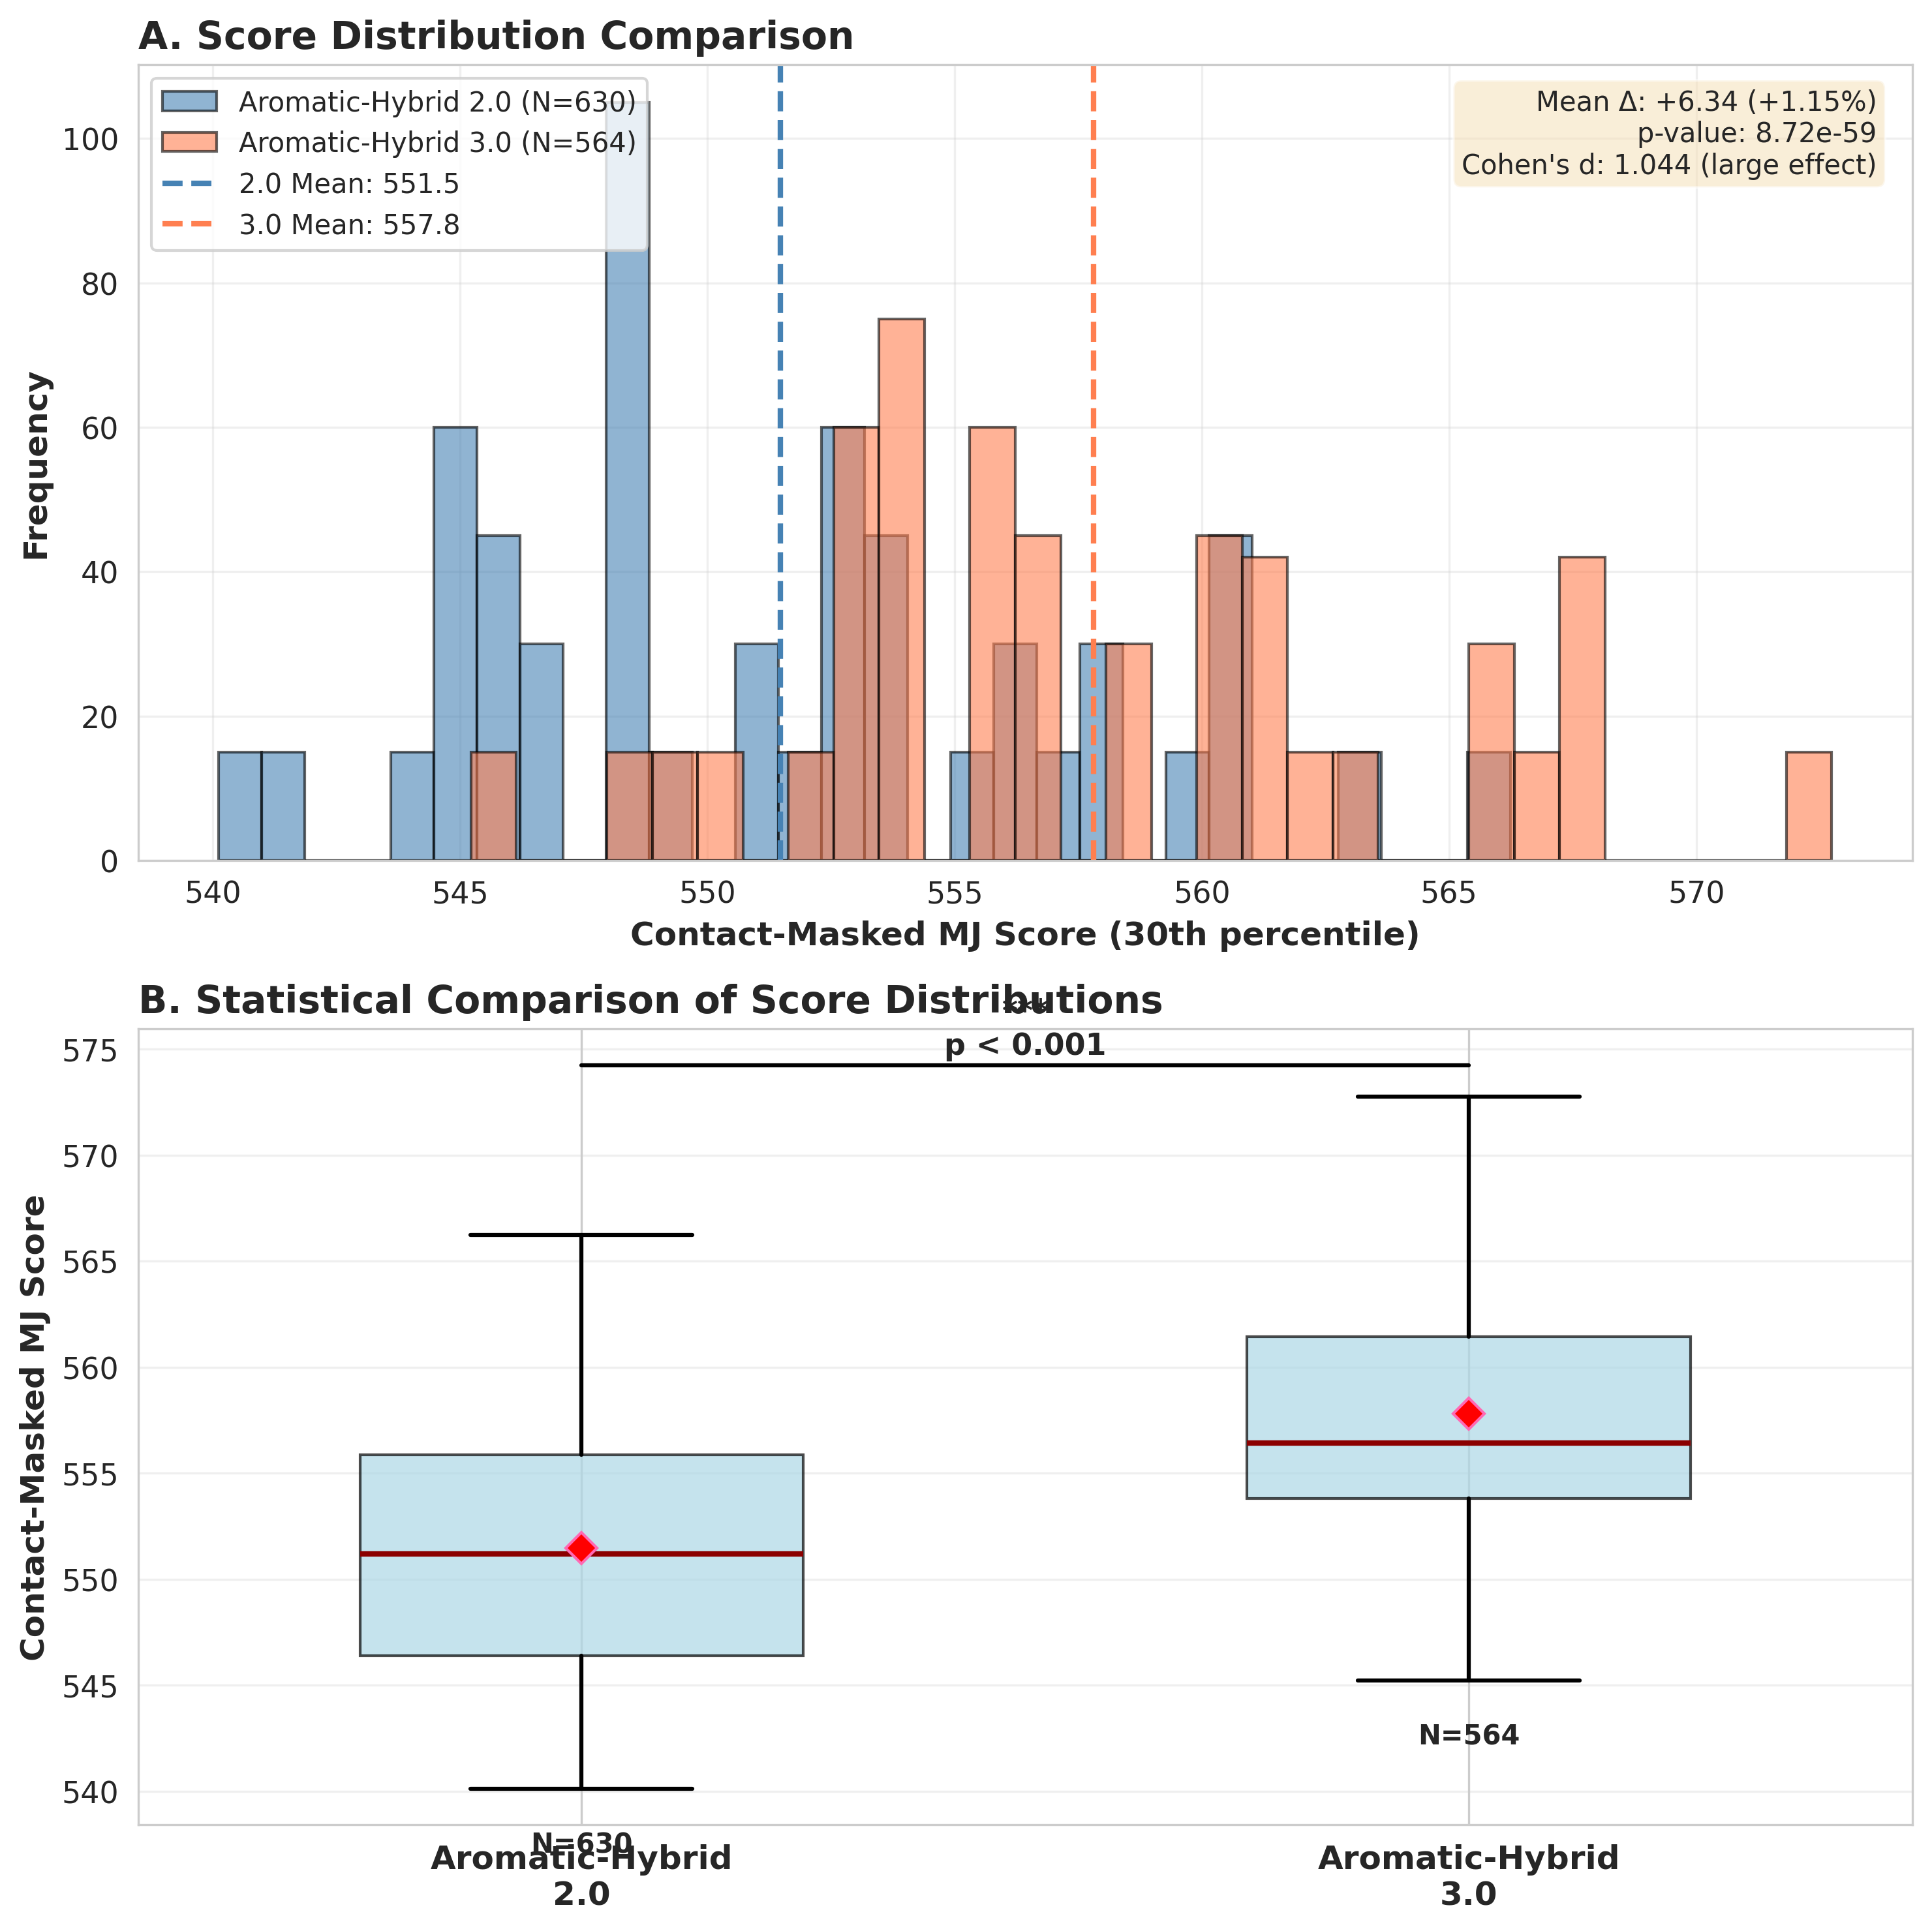


=== FINAL SUMMARY ===
Aromatic-Hybrid 3.0 library: 564 designs
Mean score: 557.81 ± 6.13
Improvement over 2.0: +6.34 (1.15%)
Statistical significance: p = 8.72e-59 (Mann-Whitney U test)
Effect size: Cohen's d = 1.044 (large effect)

✓ Hypothesis CONFIRMED: Third mutation yields significant improvement


In [ ]:

# Create a summary visualization comparing the two libraries
# This will be the final figure showing the key results

import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['font.size'] = 11

# Create figure with 2 subplots (vertical layout)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Subplot A: Score distributions
ax1.hist(scores_2_0_consistent, bins=30, alpha=0.6, label='Aromatic-Hybrid 2.0 (N=630)', 
         color='steelblue', edgecolor='black')
ax1.hist(scores_3_0_consistent, bins=30, alpha=0.6, label='Aromatic-Hybrid 3.0 (N=564)', 
         color='coral', edgecolor='black')
ax1.axvline(scores_2_0_consistent.mean(), color='steelblue', linestyle='--', linewidth=2, 
            label=f'2.0 Mean: {scores_2_0_consistent.mean():.1f}')
ax1.axvline(scores_3_0_consistent.mean(), color='coral', linestyle='--', linewidth=2, 
            label=f'3.0 Mean: {scores_3_0_consistent.mean():.1f}')
ax1.set_xlabel('Contact-Masked MJ Score (30th percentile)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax1.set_title('A. Score Distribution Comparison', fontsize=14, fontweight='bold', loc='left')
ax1.legend(loc='upper left', frameon=True, fontsize=10)
ax1.grid(True, alpha=0.3)

# Add statistics text box
stats_text = (f'Mean Δ: +{mean_diff:.2f} (+{100*mean_diff/scores_2_0_consistent.mean():.2f}%)\n'
              f'p-value: {p_mannwhitney:.2e}\n'
              f"Cohen's d: {cohens_d:.3f} (large effect)")
ax1.text(0.98, 0.97, stats_text, transform=ax1.transAxes, fontsize=10,
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Subplot B: Box plots with individual data points
positions = [1, 2]
bp1 = ax2.boxplot([scores_2_0_consistent, scores_3_0_consistent], positions=positions,
                   widths=0.5, patch_artist=True, showmeans=True,
                   meanprops=dict(marker='D', markerfacecolor='red', markersize=8),
                   medianprops=dict(color='darkred', linewidth=2),
                   boxprops=dict(facecolor='lightblue', alpha=0.7),
                   whiskerprops=dict(linewidth=1.5),
                   capprops=dict(linewidth=1.5))

ax2.set_xticks(positions)
ax2.set_xticklabels(['Aromatic-Hybrid\n2.0', 'Aromatic-Hybrid\n3.0'], fontsize=12, fontweight='bold')
ax2.set_ylabel('Contact-Masked MJ Score', fontsize=12, fontweight='bold')
ax2.set_title('B. Statistical Comparison of Score Distributions', fontsize=14, fontweight='bold', loc='left')
ax2.grid(True, alpha=0.3, axis='y')

# Add sample sizes and statistics
ax2.text(1, scores_2_0_consistent.min()-3, f'N={len(scores_2_0_consistent)}', 
         ha='center', fontsize=10, fontweight='bold')
ax2.text(2, scores_3_0_consistent.min()-3, f'N={len(scores_3_0_consistent)}', 
         ha='center', fontsize=10, fontweight='bold')

# Add connecting line showing improvement
y_connect = scores_2_0_consistent.max() + 8
ax2.plot([1, 2], [y_connect, y_connect], 'k-', linewidth=1.5)
ax2.text(1.5, y_connect + 0.5, f'***\np < 0.001', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('aromatic_hybrid_3.0_evaluation.png', dpi=300, bbox_inches='tight')
print("Final figure saved as 'aromatic_hybrid_3.0_evaluation.png'")
plt.show()

print("\n=== FINAL SUMMARY ===")
print(f"Aromatic-Hybrid 3.0 library: {len(scores_3_0_consistent)} designs")
print(f"Mean score: {scores_3_0_consistent.mean():.2f} ± {scores_3_0_consistent.std():.2f}")
print(f"Improvement over 2.0: +{mean_diff:.2f} ({100*mean_diff/scores_2_0_consistent.mean():.2f}%)")
print(f"Statistical significance: p = {p_mannwhitney:.2e} (Mann-Whitney U test)")
print(f"Effect size: Cohen's d = {cohens_d:.3f} (large effect)")
print(f"\n✓ Hypothesis CONFIRMED: Third mutation yields significant improvement")


In [ ]:

# Update the saved CSV file with corrected scores (negated for "higher is better" convention)
output_df_corrected = novel_df_sorted[['Scaffold', 'Parent_Motif', 'Motif', 'Third_Mutation', 
                                        'Third_Mut_Type', 'Design_Sequence', 'Contact_Masked_MJ_Score']].copy()

output_df_corrected.to_csv('aromatic_hybrid_3.0_designs.csv', index=False)
print(f"Updated aromatic_hybrid_3.0_designs.csv with corrected scores (N={len(output_df_corrected)})")
print("\nTop 10 designs with corrected scores:")
print(output_df_corrected[['Motif', 'Scaffold', 'Third_Mutation', 'Contact_Masked_MJ_Score']].head(10))


Updated aromatic_hybrid_3.0_designs.csv with corrected scores (N=564)

Top 10 designs with corrected scores:
         Motif Scaffold Third_Mutation  Contact_Masked_MJ_Score
461  WWCLICILI     2QMT            Q2W                   572.74
460  WWCLICILI     1TEN            Q2W                   572.74
459  WWCLICILI     1FNA            Q2W                   572.74
133  IWCLWCLII     1TEN            Q2W                   572.74
134  IWCLWCLII     2QMT            Q2W                   572.74
132  IWCLWCLII     1FNA            Q2W                   572.74
19   IWCLLCWII     1TEN            Q2W                   572.74
20   IWCLLCWII     2QMT            Q2W                   572.74
348  WWCLICLII     1FNA            Q2W                   572.74
350  WWCLICLII     2QMT            Q2W                   572.74
